# UK Road Safety - Accident Severity Data Analysis

## Project Overview

The UK Department of Transport has released data on reported road accidents to the public from 1979. The information provided only relates to personal injury accidents that occur on public roads and that are reported to the police. This project uses the 2020 accident dataset. 

The goal of this project is to:
- Explore the road safety accident dataset
- Apply the Stochastic Gradient Descent optimisation technique with a logistic regression loss function

Specifically, this will be treated as a classification problem with a binary target (response) variable.

## Data & Project Setup

The accidents dataset contains high-level information on the nature of the accident, the location, severity, date the accident took place, road and weather conditions, etc.

Specific features are selected from the data to be included in the model and feature engineering is conducted to adjust and create new features.

In [440]:
# Import libraries
import numpy as np 
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette("Dark2")

In [441]:
# Load data
accidents_col_list = ['accident_index',
       'longitude', 'latitude', 'accident_severity',
       'date', 'day_of_week', 'time', 'speed_limit',
       'light_conditions', 'road_surface_conditions',
       'urban_or_rural_area', 'number_of_vehicles']

accidents = pd.read_csv("data/accident.csv", 
                        sep = ',', 
                        usecols = accidents_col_list,
                        dtype = {'accident_index': str})

In [442]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   accident_index           91199 non-null  object 
 1   longitude                91185 non-null  float64
 2   latitude                 91185 non-null  float64
 3   accident_severity        91199 non-null  int64  
 4   number_of_vehicles       91199 non-null  int64  
 5   date                     91199 non-null  object 
 6   day_of_week              91199 non-null  int64  
 7   time                     91199 non-null  object 
 8   speed_limit              91199 non-null  int64  
 9   light_conditions         91199 non-null  int64  
 10  road_surface_conditions  91199 non-null  int64  
 11  urban_or_rural_area      91199 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 8.3+ MB


In [443]:
accidents.head(10)

,accident_index,longitude,latitude,accident_severity,number_of_vehicles,date,day_of_week,time,speed_limit,light_conditions,road_surface_conditions,urban_or_rural_area
0,2020010219808,-0.254001,51.462262,3,1,04/02/2020,3,09:00,20,1,9,1
1,2020010220496,-0.139253,51.470327,3,1,27/04/2020,2,13:55,20,1,1,1
2,2020010228005,-0.178719,51.529614,3,1,01/01/2020,4,01:25,30,4,2,1
3,2020010228006,-0.001683,51.541210,2,1,01/01/2020,4,01:50,30,4,1,1
4,2020010228011,-0.137592,51.515704,3,1,01/01/2020,4,02:25,30,4,1,1
5,2020010228012,-0.025880,51.476278,3,1,01/01/2020,4,01:30,20,4,1,1
6,2020010228014,0.011959,51.494780,3,2,01/01/2020,4,03:43,30,4,2,1
7,2020010228017,-0.039390,51.523195,2,2,01/01/2020,4,03:00,30,4,2,1
8,2020010228018,-0.111500,51.605653,3,2,01/01/2020,4,04:00,20,4,1,1
9,2020010228020,-0.127840,51.614971,3,2,01/01/2020,4,03:25,30,4,1,1


In [444]:
accidents.describe()

,longitude,latitude,accident_severity,number_of_vehicles,day_of_week,speed_limit,light_conditions,road_surface_conditions,urban_or_rural_area
count,91185.000000,91185.000000,91199.000000,91199.000000,91199.000000,91199.000000,91199.000000,91199.000000,91199.000000
mean,-1.189258,52.351073,2.768232,1.835272,4.121558,36.270113,2.065308,1.391583,1.323205
std,1.367786,1.327573,0.456682,0.677272,1.932200,13.896032,1.747690,0.925690,0.468031
min,-7.497375,49.970479,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,-2.107789,51.457237,3.000000,1.000000,2.000000,30.000000,1.000000,1.000000,1.000000
50%,-1.046912,51.763385,3.000000,2.000000,4.000000,30.000000,1.000000,1.000000,1.000000
75%,-0.125238,53.297386,3.000000,2.000000,6.000000,40.000000,4.000000,2.000000,2.000000
max,1.756257,60.541144,3.000000,13.000000,7.000000,70.000000,7.000000,9.000000,3.000000


In [445]:
# Split accidents data into train & test sets
train_accidents, test_accidents = train_test_split(accidents, test_size = 0.2, shuffle = True, random_state = 42)

In [446]:
# Make a copy of the training data for the exploration phase
accidents_copy = train_accidents.copy()

In [447]:
# Replace -1 with null
accidents_copy = accidents_copy.replace(-1, np.nan)
# Replace unknown (9) with null
accidents_copy = accidents_copy.replace(9, np.nan)

# Remove nulls
accidents_copy = accidents_copy.dropna()

### Data Description

- accident_index
- longitude
- latitude
- accident_severity: 1 = fatal, 2 = serious, 3 = slight
- number_of_vehicles
- date
- day_of_week: 1-7 = Sun-Sat
- time
- speed_limit: 20, 30, 40, 50, 60, 70, -1 = data missing, 99 = unknown
- light_conditions: 1 = daylight, 4 = darkness - lights lit, 5 = darkness - lights unlit, 
                  6 = darkness - no lighting, 7 = darkness - lighting unknown, -1 = data missing
- road_surface_conditions: 1 = dry, 2 = wet or damp, 3 = snow, 4 = frost or ice, 
                         5 = flood over 3cm, deep, 6 = oil or diesel, 7 = mud, 
                         -1 = data missing, 9 = unknown
- urban_or_rural_area: 1 = urban, 2 = rural, 3 = unallocated, -1 = data missing

## Data Exploration

In [448]:
# Number of vehicles
accidents_copy.groupby("number_of_vehicles")["accident_index"].count()

number_of_vehicles
1.0     20428
2.0     45201
3.0      4908
4.0      1064
5.0       267
6.0        80
7.0        37
8.0        12
10.0        3
11.0        2
12.0        1
13.0        1
Name: accident_index, dtype: int64

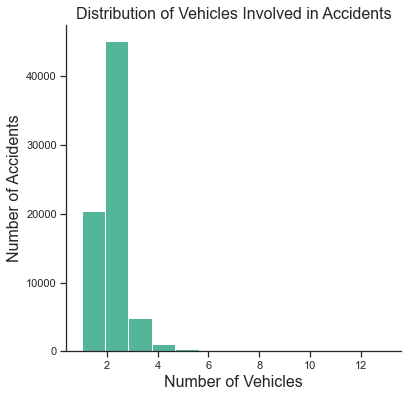

In [449]:
plt.figure(figsize = (6, 6))
sns.histplot(data = accidents_copy, x = "number_of_vehicles", bins = 13)
plt.xlabel("Number of Vehicles", fontsize=16)
plt.ylabel("Number of Accidents", fontsize=16)
plt.title("Distribution of Vehicles Involved in Accidents", fontsize=16)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Figure size 432x432 with 0 Axes>

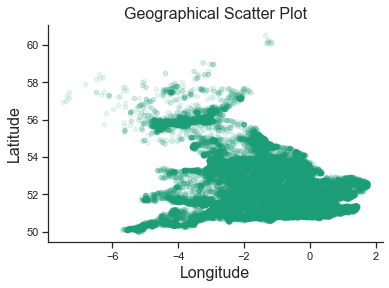

In [486]:
# Geographical plot
plt.figure(figsize = (6, 6))
accidents_copy.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)
plt.title("Geographical Scatter Plot", fontsize=16)
plt.show()

In [451]:
# Accident severity

# Combine the categories for accident severity to create a binary variable
# 1 = fatal/serious, 0 = slight
accidents_copy.loc[(accidents_copy["accident_severity"] == 2), "accident_severity"] = 1
accidents_copy.loc[(accidents_copy["accident_severity"] == 3), "accident_severity"] = 0

# Calculate percentange of accidents at each severity
accident_severity_percent = pd.DataFrame()
accident_severity_percent["Count"] = accidents_copy.groupby("accident_severity")["accident_index"].count()
accident_severity_percent["Percent"] = accident_severity_percent["Count"] / accident_severity_percent["Count"].sum() * 100
accident_severity_percent["Percent"] = accident_severity_percent["Percent"].astype(int)

accident_severity_percent

,Count,Percent
accident_severity,,
0,56302,78
1,15702,21


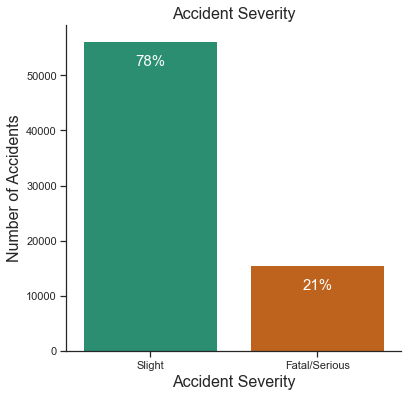

In [452]:
slight = accident_severity_percent["Percent"].iloc[0]
fatal_serious = accident_severity_percent["Percent"].iloc[1]

# Plot counts & percentages on a bar chart
plt.figure(figsize = (6, 6))
sns.countplot(data = accidents_copy, x = "accident_severity")

plt.annotate(str(slight)+"%", xy=(0,accident_severity_percent["Count"].iloc[0]-4500), color = 'white', size = 15, ha = 'center')
plt.annotate(str(fatal_serious)+"%", xy=(1, accident_severity_percent["Count"].iloc[1]-4500), color = 'white', size = 15, ha = 'center')

plt.xticks([0, 1], labels = ["Slight", "Fatal/Serious"])
plt.xlabel("Accident Severity", fontsize=16)
plt.ylabel("Number of Accidents", fontsize=16)
plt.title("Accident Severity", fontsize=16)
plt.show()

In [453]:
# Convert time column to time format
accidents_copy['time'] = pd.to_datetime(accidents_copy['time'], format = "%H:%M")

In [454]:
# Time of day

# Create a time category variable from the hour of the day
accidents_copy["time_category"] = accidents_copy['time'].dt.hour

# Combine the values for time of day into 3 categories
# 1 = morning (5am-12pm), 2 = afternoon (12pm=5pm), 3 = evening (5pm-5am)
accidents_copy.loc[(accidents_copy["time_category"] >= 20) | (accidents_copy["time_category"] < 4), "time_category"] = 3
accidents_copy.loc[(accidents_copy["time_category"] >= 4) & (accidents_copy["time_category"] < 12), "time_category"] = 1
accidents_copy.loc[(accidents_copy["time_category"] >= 12) & (accidents_copy["time_category"] < 20), "time_category"] = 2

# Calculate percentange of accidents for each time category
time_category_percent = pd.DataFrame()
time_category_percent["Count"] = accidents_copy.groupby("time_category")["accident_index"].count()
time_category_percent["Percent"] = time_category_percent["Count"] / time_category_percent["Count"].sum() * 100
time_category_percent["Percent"] = time_category_percent["Percent"].astype(int)

time_category_percent

,Count,Percent
time_category,,
1,19831,27
2,40741,56
3,11432,15


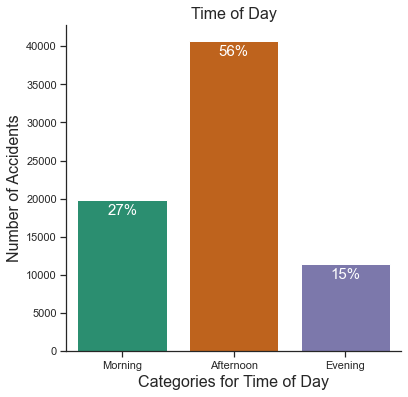

In [455]:
morning = time_category_percent["Percent"].iloc[0]
afternoon = time_category_percent["Percent"].iloc[1]
evening = time_category_percent["Percent"].iloc[2]

# Plot counts & percentages on a bar chart
plt.figure(figsize = (6, 6))
sns.countplot(data = accidents_copy, x = "time_category")

plt.annotate(str(morning)+"%", xy=(0,time_category_percent["Count"].iloc[0]-2000), color = 'white', size = 15, ha = 'center')
plt.annotate(str(afternoon)+"%", xy=(1, time_category_percent["Count"].iloc[1]-2000), color = 'white', size = 15, ha = 'center')
plt.annotate(str(evening)+"%", xy=(2, time_category_percent["Count"].iloc[2]-2000), color = 'white', size = 15, ha = 'center')

plt.xticks([0, 1, 2], labels = ["Morning", "Afternoon", "Evening"])
plt.xlabel("Categories for Time of Day", fontsize=16)
plt.ylabel("Number of Accidents", fontsize=16)
plt.title("Time of Day", fontsize=16)
plt.show()

In [456]:
# Day of the week
# Calculate percentange of accidents for each day of the week
day_of_week_percent = pd.DataFrame()
day_of_week_percent["Count"] = accidents_copy.groupby("day_of_week")["accident_index"].count()
day_of_week_percent["Percent"] = day_of_week_percent["Count"] / day_of_week_percent["Count"].sum() * 100
day_of_week_percent["Percent"] = day_of_week_percent["Percent"].astype(int)

day_of_week_percent

,Count,Percent
day_of_week,,
1,8048,11
2,10067,13
3,10465,14
4,10689,14
5,11181,15
6,11785,16
7,9769,13


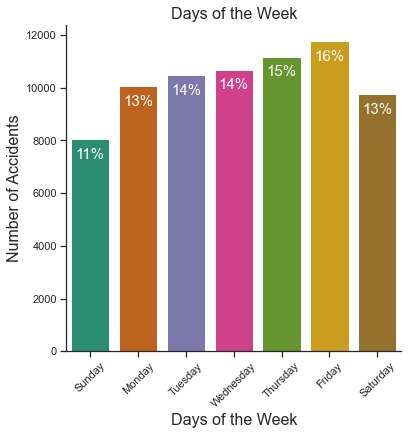

In [457]:
# Percentage of accidents for each day of the week
sunday = day_of_week_percent["Percent"].iloc[0]
monday = day_of_week_percent["Percent"].iloc[1]
tuesday = day_of_week_percent["Percent"].iloc[2]
wednesday = day_of_week_percent["Percent"].iloc[3]
thursday = day_of_week_percent["Percent"].iloc[4]
friday = day_of_week_percent["Percent"].iloc[5]
saturday = day_of_week_percent["Percent"].iloc[6]

# Plot counts & percentages on a bar chart
plt.figure(figsize = (6, 6))
sns.countplot(data = accidents_copy, x = "day_of_week")

plt.annotate(str(sunday)+"%", xy=(0, day_of_week_percent["Count"].iloc[0]-750), color = 'white', size = 15, ha = 'center')
plt.annotate(str(monday)+"%", xy=(1,day_of_week_percent["Count"].iloc[1]-750), color = 'white', size = 15, ha = 'center')
plt.annotate(str(tuesday)+"%", xy=(2,day_of_week_percent["Count"].iloc[2]-750), color = 'white', size = 15, ha = 'center')
plt.annotate(str(wednesday)+"%", xy=(3,day_of_week_percent["Count"].iloc[3]-750), color = 'white', size = 15, ha = 'center')
plt.annotate(str(thursday)+"%", xy=(4,day_of_week_percent["Count"].iloc[4]-750), color = 'white', size = 15, ha = 'center')
plt.annotate(str(friday)+"%", xy=(5,day_of_week_percent["Count"].iloc[5]-750), color = 'white', size = 15, ha = 'center')
plt.annotate(str(saturday)+"%", xy=(6,day_of_week_percent["Count"].iloc[6]-750), color = 'white', size = 15, ha = 'center')

plt.xticks([0, 1, 2, 3, 4, 5, 6], labels = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], rotation = 45)
plt.xlabel("Days of the Week", fontsize=16)
plt.ylabel("Number of Accidents", fontsize=16)
plt.title("Days of the Week", fontsize=16)
plt.show()

In [458]:
# Convert date column to date format
accidents_copy['date'] = pd.to_datetime(accidents_copy['date'], format = '%d/%m/%Y')

In [459]:
# Date of accident

# Create a month category variable from the date
accidents_copy["month_cat"] = accidents_copy['date'].dt.month

# Combine the months into quarters
# q1 - q4
accidents_copy.loc[(accidents_copy["month_cat"] >= 1) & (accidents_copy["month_cat"] <= 3), "month_cat"] = 1
accidents_copy.loc[(accidents_copy["month_cat"] >= 4) & (accidents_copy["month_cat"] <= 6), "month_cat"] = 2
accidents_copy.loc[(accidents_copy["month_cat"] >= 7) & (accidents_copy["month_cat"] <= 9), "month_cat"] = 3
accidents_copy.loc[(accidents_copy["month_cat"] >= 10) & (accidents_copy["month_cat"] <= 12), "month_cat"] = 4

# Calculate percentange of accidents for each quarter
month_cat_percent = pd.DataFrame()
month_cat_percent["Count"] = accidents_copy.groupby("month_cat")["accident_index"].count()
month_cat_percent["Percent"] = month_cat_percent["Count"] / month_cat_percent["Count"].sum() * 100
month_cat_percent["Percent"] = month_cat_percent["Percent"].astype(int)

month_cat_percent

,Count,Percent
month_cat,,
1,19507,27
2,12365,17
3,20749,28
4,19383,26


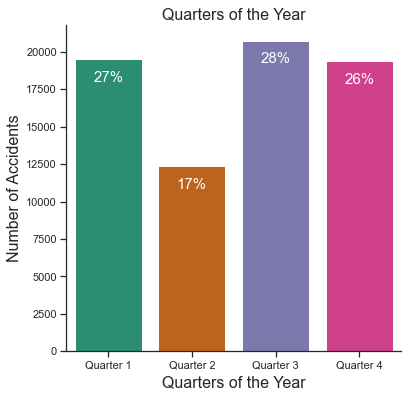

In [460]:
q1 = month_cat_percent["Percent"].iloc[0]
q2 = month_cat_percent["Percent"].iloc[1]
q3 = month_cat_percent["Percent"].iloc[2]
q4 = month_cat_percent["Percent"].iloc[3]


# Plot counts & percentages on a bar chart
plt.figure(figsize = (6, 6))
sns.countplot(data = accidents_copy, x = "month_cat")

plt.annotate(str(q1)+"%", xy=(0,month_cat_percent["Count"].iloc[0]-1500), color = 'white', size = 15, ha = 'center')
plt.annotate(str(q2)+"%", xy=(1, month_cat_percent["Count"].iloc[1]-1500), color = 'white', size = 15, ha = 'center')
plt.annotate(str(q3)+"%", xy=(2, month_cat_percent["Count"].iloc[2]-1500), color = 'white', size = 15, ha = 'center')
plt.annotate(str(q4)+"%", xy=(3, month_cat_percent["Count"].iloc[3]-1500), color = 'white', size = 15, ha = 'center')

plt.xticks([0, 1, 2, 3], labels = ["Quarter 1", "Quarter 2", "Quarter 3", "Quarter 4"])
plt.xlabel("Quarters of the Year", fontsize=16)
plt.ylabel("Number of Accidents", fontsize=16)
plt.title("Quarters of the Year", fontsize=16)
plt.show()

In [461]:
# Speed limit

# Combine the categories for speed limit to create a binary variable
# 1 = >30, 0 = <=30
accidents_copy.loc[(accidents_copy["speed_limit"] > 30), "speed_limit"] = 1
accidents_copy.loc[(accidents_copy["speed_limit"] > 1) & (accidents_copy["speed_limit"] <= 30), "speed_limit"] = 0

# Calculate percentange of accidents for each speed limit
speed_limit_percent = pd.DataFrame()
speed_limit_percent["Count"] = accidents_copy.groupby("speed_limit")["accident_index"].count()
speed_limit_percent["Percent"] = speed_limit_percent["Count"] / speed_limit_percent["Count"].sum() * 100
speed_limit_percent["Percent"] = speed_limit_percent["Percent"].astype(int)

speed_limit_percent

,Count,Percent
speed_limit,,
0.0,49971,69
1.0,22033,30


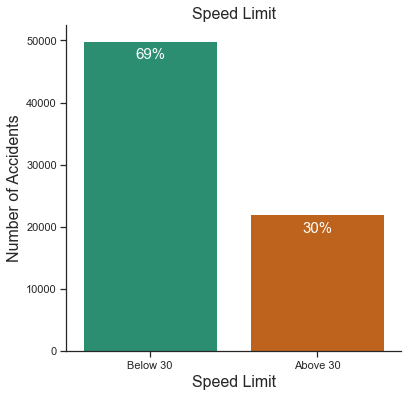

In [462]:
# Percentage of accidents for each speed limit
below_30 = speed_limit_percent["Percent"].iloc[0]
over_30 = speed_limit_percent["Percent"].iloc[1]

# Plot counts & percentages on a bar chart
plt.figure(figsize = (6, 6))
sns.countplot(data = accidents_copy, x = "speed_limit")

plt.annotate(str(below_30)+"%", xy=(0, speed_limit_percent["Count"].iloc[0]-3000), color = 'white', size = 15, ha = 'center')
plt.annotate(str(over_30)+"%", xy=(1,speed_limit_percent["Count"].iloc[1]-3000), color = 'white', size = 15, ha = 'center')

plt.xticks([0, 1], labels = ["Below 30", "Above 30"])
plt.xlabel("Speed Limit", fontsize=16)
plt.ylabel("Number of Accidents", fontsize=16)
plt.title("Speed Limit", fontsize=16)
plt.show()

In [463]:
# Light conditions

# Combine the categories for light conditions to create a binary variable
# 1 = darkness, 0 = daylight
accidents_copy.loc[(accidents_copy["light_conditions"] == 1), "light_conditions"] = 0
accidents_copy.loc[(accidents_copy["light_conditions"] > 1), "light_conditions"] = 1

# Calculate percentange of accidents for each lighting condition
light_conditions_percent = pd.DataFrame()
light_conditions_percent["Count"] = accidents_copy.groupby("light_conditions")["accident_index"].count()
light_conditions_percent["Percent"] = light_conditions_percent["Count"] / light_conditions_percent["Count"].sum() * 100
light_conditions_percent["Percent"] = light_conditions_percent["Percent"].astype(int)

light_conditions_percent

,Count,Percent
light_conditions,,
0,50905,70
1,21099,29


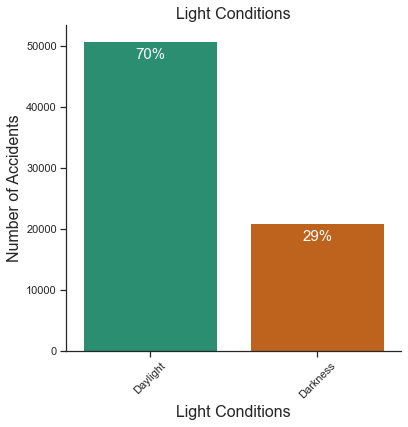

In [464]:
# Percentage of accidents for each lighting condition
daylight = light_conditions_percent["Percent"].iloc[0]
darkness = light_conditions_percent["Percent"].iloc[1]

# Plot counts & percentages on a bar chart
plt.figure(figsize = (6, 6))
sns.countplot(data = accidents_copy, x = "light_conditions")

plt.annotate(str(daylight)+"%", xy=(0, light_conditions_percent["Count"].iloc[0]-3000), color = 'white', size = 15, ha = 'center')
plt.annotate(str(darkness)+"%", xy=(1,light_conditions_percent["Count"].iloc[1]-3000), color = 'white', size = 15, ha = 'center')

plt.xticks([0, 1], labels = ["Daylight", "Darkness"], rotation = 45)
plt.xlabel("Light Conditions", fontsize=16)
plt.ylabel("Number of Accidents", fontsize=16)
plt.title("Light Conditions", fontsize=16)
plt.show()

In [465]:
# Road surface conditions

# Combine the categories for road surface conditions to create a binary variable
# 1 = wet/other, 0 = dry
accidents_copy.loc[(accidents_copy["road_surface_conditions"] == 1), "road_surface_conditions"] = 0
accidents_copy.loc[(accidents_copy["road_surface_conditions"] > 1), "road_surface_conditions"] = 1

# Calculate percentange of accidents for each lighting condition
road_surface_conditions_percent = pd.DataFrame()
road_surface_conditions_percent["Count"] = accidents_copy.groupby("road_surface_conditions")["accident_index"].count()
road_surface_conditions_percent["Percent"] = road_surface_conditions_percent["Count"] / road_surface_conditions_percent["Count"].sum() * 100
road_surface_conditions_percent["Percent"] = road_surface_conditions_percent["Percent"].astype(int)

road_surface_conditions_percent

,Count,Percent
road_surface_conditions,,
0.0,50058,69
1.0,21946,30


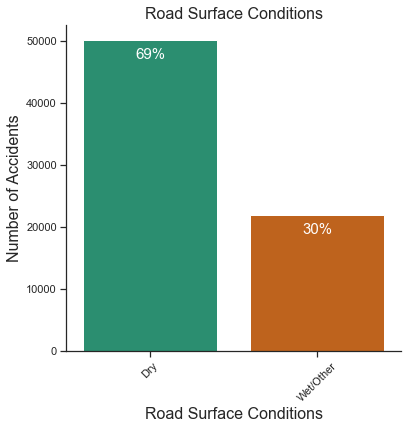

In [466]:
# Percentage of accidents for each road condition
dry = road_surface_conditions_percent["Percent"].iloc[0]
wet_other = road_surface_conditions_percent["Percent"].iloc[1]

# Plot counts & percentages on a bar chart
plt.figure(figsize = (6, 6))
sns.countplot(data = accidents_copy, x = "road_surface_conditions")

plt.annotate(str(dry)+"%", xy=(0, road_surface_conditions_percent["Count"].iloc[0]-3000), color = 'white', size = 15, ha = 'center')
plt.annotate(str(wet_other)+"%", xy=(1,road_surface_conditions_percent["Count"].iloc[1]-3000), color = 'white', size = 15, ha = 'center')

plt.xticks([0, 1], labels = ["Dry", "Wet/Other"], rotation = 45)
plt.xlabel("Road Surface Conditions", fontsize=16)
plt.ylabel("Number of Accidents", fontsize=16)
plt.title("Road Surface Conditions", fontsize=16)
plt.show()

In [467]:
# Urban or rural area

# Combine the categories for road surface conditions to create a binary variable
# 1 = urban, 0 = rural
accidents_copy.loc[(accidents_copy["urban_or_rural_area"] == 2), "urban_or_rural_area"] = 0

# Calculate percentange of accidents for each lighting condition
urban_or_rural_area_percent = pd.DataFrame()
urban_or_rural_area_percent["Count"] = accidents_copy.groupby("urban_or_rural_area")["accident_index"].count()
urban_or_rural_area_percent["Percent"] = urban_or_rural_area_percent["Count"] / urban_or_rural_area_percent["Count"].sum() * 100
urban_or_rural_area_percent["Percent"] = urban_or_rural_area_percent["Percent"].astype(int)

urban_or_rural_area_percent

,Count,Percent
urban_or_rural_area,,
0,23414,32
1,48590,67


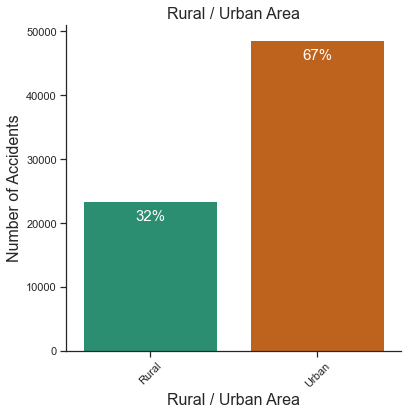

In [468]:
# Percentage of accidents for urban/rural area
rural = urban_or_rural_area_percent["Percent"].iloc[0]
urban = urban_or_rural_area_percent["Percent"].iloc[1]

# Plot counts & percentages on a bar chart
plt.figure(figsize = (6, 6))
sns.countplot(data = accidents_copy, x = "urban_or_rural_area")

plt.annotate(str(rural)+"%", xy=(0, urban_or_rural_area_percent["Count"].iloc[0]-3000), color = 'white', size = 15, ha = 'center')
plt.annotate(str(urban)+"%", xy=(1,urban_or_rural_area_percent["Count"].iloc[1]-3000), color = 'white', size = 15, ha = 'center')

plt.xticks([0, 1], labels = ["Rural", "Urban"], rotation = 45)
plt.xlabel("Rural / Urban Area", fontsize=16)
plt.ylabel("Number of Accidents", fontsize=16)
plt.title("Rural / Urban Area", fontsize=16)
plt.show()

## Data Processing

In [469]:
# Clean up bad values and remove nulls

# Replace -1 with null
train_accidents = train_accidents.replace(-1, np.nan)
# Replace unknown (9) with null
train_accidents = train_accidents.replace(9, np.nan)
# Remove nulls
train_accidents = train_accidents.dropna()

In [470]:
# Split out features & target
train_features = train_accidents.drop(["accident_severity", "accident_index"], axis = 1)
train_target = train_accidents["accident_severity"].copy()

In [471]:
# Transformations

# Combine the categories for accident severity (target) to create a binary variable
# 1 = fatal/serious, 0 = slight
train_target.loc[(train_target == 2)] = 1
train_target.loc[(train_target == 3)] = 0

# Time of day

# Convert time column to time format
train_features['time'] = pd.to_datetime(train_features['time'], format = "%H:%M")

# Create a time category variable from the hour of the day
train_features["time_category"] = train_features['time'].dt.hour

# Combine the values for time of day into 3 categories
# 1 = morning (5am-12pm), 2 = afternoon (12pm=5pm), 3 = evening (5pm-5am)
train_features.loc[(train_features["time_category"] >= 20) | (train_features["time_category"] < 4), "time_category"] = 3
train_features.loc[(train_features["time_category"] >= 4) & (train_features["time_category"] < 12), "time_category"] = 1
train_features.loc[(train_features["time_category"] >= 12) & (train_features["time_category"] < 20), "time_category"] = 2

# Date of accident

# Convert date column to date format
train_features['date'] = pd.to_datetime(train_features['date'], format = '%d/%m/%Y')

# Create a month category variable from the date
train_features["month_cat"] = train_features['date'].dt.month

# Combine the months into quarters
# q1 - q4
train_features.loc[(train_features["month_cat"] >= 1) & (train_features["month_cat"] <= 3), "month_cat"] = 1
train_features.loc[(train_features["month_cat"] >= 4) & (train_features["month_cat"] <= 6), "month_cat"] = 2
train_features.loc[(train_features["month_cat"] >= 7) & (train_features["month_cat"] <= 9), "month_cat"] = 3
train_features.loc[(train_features["month_cat"] >= 10) & (train_features["month_cat"] <= 12), "month_cat"] = 4

# Speed limit

# Combine the categories for speed limit to create a binary variable
# 1 = >30, 0 = <=30
train_features.loc[(train_features["speed_limit"] > 30), "speed_limit"] = 1
train_features.loc[(train_features["speed_limit"] > 1) & (train_features["speed_limit"] <= 30), "speed_limit"] = 0

# Light conditions

# Combine the categories for light conditions to create a binary variable
# 1 = darkness, 0 = daylight
train_features.loc[(train_features["light_conditions"] == 1), "light_conditions"] = 0
train_features.loc[(train_features["light_conditions"] > 1), "light_conditions"] = 1

# Road surface conditions

# Combine the categories for road surface conditions to create a binary variable
# 1 = wet/other, 0 = dry
train_features.loc[(train_features["road_surface_conditions"] == 1), "road_surface_conditions"] = 0
train_features.loc[(train_features["road_surface_conditions"] > 1), "road_surface_conditions"] = 1

# Urban or rural area

# Combine the categories for road surface conditions to create a binary variable
# 1 = urban, 0 = rural
train_features.loc[(train_features["urban_or_rural_area"] == 2), "urban_or_rural_area"] = 0

In [472]:
# Onehotencoder for the time & month category features
onehot_df = train_features[["day_of_week", "time_category", "month_cat"]]
onehot = OneHotEncoder(drop = 'first', sparse = False)
onehot_df = pd.DataFrame(onehot.fit_transform(onehot_df), columns = onehot.get_feature_names(["day_of_week", "time_category", "month_cat"]))
onehot_df

,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,time_category_2,time_category_3,month_cat_2,month_cat_3,month_cat_4
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
71999,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
72000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
72001,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
72002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [473]:
# Add onehotencoder features back to train set
train_features.reset_index(drop=True, inplace=True)
train_features = pd.concat([train_features, onehot_df], axis = 1)

In [474]:
# Remove redundant columns
train_features = train_features.drop(["date", "time", "day_of_week", "time_category", "month_cat"], axis = 1)

In [475]:
# Standardise the continuous features
scaler = StandardScaler()
train_features_scaled = train_features.copy()
features_to_scale = train_features_scaled[["longitude", "latitude", "number_of_vehicles"]]
features_to_scale = scaler.fit_transform(features_to_scale.values)
train_features_scaled[["longitude", "latitude", "number_of_vehicles"]] = features_to_scale

train_features_scaled.describe()

,longitude,latitude,number_of_vehicles,speed_limit,light_conditions,road_surface_conditions,urban_or_rural_area,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,time_category_2,time_category_3,month_cat_2,month_cat_3,month_cat_4
count,7.200400e+04,7.200400e+04,7.200400e+04,72004.000000,72004.000000,72004.000000,72004.000000,72004.000000,72004.000000,72004.000000,72004.000000,72004.000000,72004.000000,72004.000000,72004.000000,72004.000000,72004.000000,72004.000000
mean,1.120631e-16,-3.256180e-16,-5.352038e-16,0.305997,0.293025,0.304789,0.674824,0.139812,0.145339,0.148450,0.155283,0.163671,0.135673,0.565816,0.158769,0.171727,0.288165,0.269193
std,1.000007e+00,1.000007e+00,1.000007e+00,0.460832,0.455153,0.460321,0.468444,0.346794,0.352445,0.355548,0.362177,0.369980,0.342443,0.495653,0.365463,0.377145,0.452911,0.443544
min,-4.590231e+00,-1.790226e+00,-1.227819e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.707644e-01,-6.747314e-01,-1.227819e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.512052e-02,-4.367321e-01,2.443452e-01,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,7.813714e-01,7.164411e-01,2.443452e-01,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,2.154082e+00,6.146770e+00,1.643815e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Training the Model

In [476]:
sgd_clf = SGDClassifier(random_state = 42, loss = 'log')
sgd_clf.fit(train_features_scaled, train_target)

SGDClassifier(loss='log', random_state=42)

In [477]:
sgd_clf.coef_

array([[ 0.00742785,  0.17242295, -0.04188371,  0.17949387,  0.14227696,
        -0.05384137, -0.23451966, -0.01372821, -0.0435307 , -0.15466506,
        -0.04720194, -0.14032179, -0.09929478, -0.08512071,  0.00383528,
         0.32672862,  0.1660029 ,  0.02548214]])

In [478]:
# Evaluate the classifier
cross_val_score(sgd_clf, train_features_scaled, train_target, cv = 10, scoring = "accuracy")

array([0.7807249 , 0.78197473, 0.78100264, 0.78169699, 0.78194444,
       0.78236111, 0.78194444, 0.78222222, 0.78180556, 0.78236111])

In [479]:
# Confusion matrix
train_target_pred = cross_val_predict(sgd_clf, train_features_scaled, train_target, cv = 10)

In [480]:
conf_matrix = confusion_matrix(train_target, train_target_pred)
conf_matrix = pd.DataFrame(conf_matrix, columns = ["Pred_Neg", "Pred_Pos"], index = ["Actual_Neg", "Actual_Pos"])
conf_matrix

,Pred_Neg,Pred_Pos
Actual_Neg,56155,147
Actual_Pos,15564,138


In [481]:
# Precision & Recall
print("Precision: ", round(precision_score(train_target, train_target_pred)*100,2))
print("Recall: ", round(recall_score(train_target, train_target_pred)*100,2))

Precision:  48.42
Recall:  0.88


Interpretation of precision and recall:

Precision: for all the accidents that the model predicts to be severe, it is correct only 48% of the time.

Recall: for all accidents that are actually severe, the model is able to correctly detect 0.88% of them.

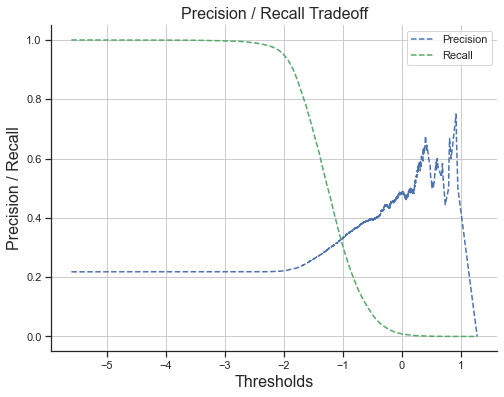

In [482]:
# Visualise the precision/recall tradeoff

# Use the cross_val_predict() function to get the scores of all instances in the training set
# Return decision scores not predictions
train_target_decision_scores = cross_val_predict(sgd_clf, train_features_scaled, train_target, cv = 10, method = "decision_function")

# Compute the precision and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(train_target, train_target_decision_scores)

# Plot precision and recall as functions of the threshold value
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
plt.plot(thresholds, recalls[:-1], "g--", label = "Recall")
plt.grid(True)

plt.legend(loc = "upper right")
plt.xlabel("Thresholds", fontsize=16)
plt.ylabel("Precision / Recall", fontsize=16)
plt.title("Precision / Recall Tradeoff", fontsize=16)
plt.show()

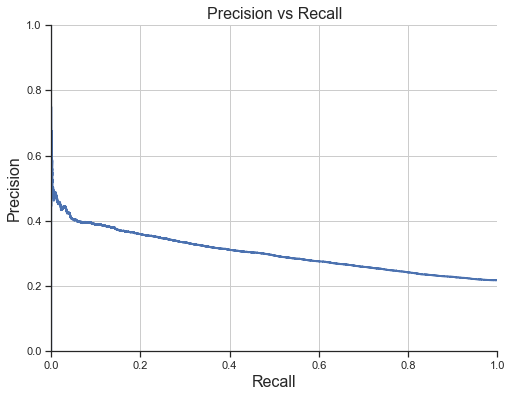

In [483]:
# Plot precision against recall

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.axis([0, 1, 0, 1])
plt.grid(True)

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.title("Precision vs Recall", fontsize=16)
plt.show()

The idea with the precision vs recall plot is that you should select a precision value at the point where the curve starts to dip and you will be able to identify the recall you would get at that level. However, the above plot shows that all the precision values are very low and if we try to maximise precision we essentially get close-to-zero recall.

Not an ideal situation as far as modelling goes.

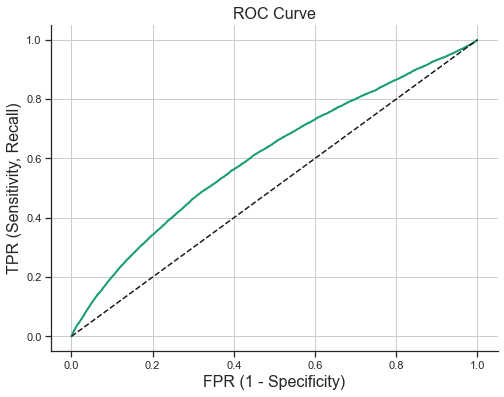

In [484]:
# The ROC Curve
# Calculate the metrics
fpr, tpr, thresholds = roc_curve(train_target, train_target_decision_scores)

# Plot FPR against TPR
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth = 2)
plt.plot([0,1], [0,1], "k--") # 45 degree line
plt.grid(True)

plt.xlabel('FPR (1 - Specificity)', fontsize=16)
plt.ylabel('TPR (Sensitivity, Recall)', fontsize=16)
plt.title('ROC Curve', fontsize=16)
plt.show()

For the ROC curve, ideally we are looking for the green line to curve as close to the top-left corner as possible. The 45-degree line represents a purely random classifier, much like flipping a fair coin. However, the chart above is quite flat for this model which is a bad sign.

In [485]:
# AUC Score
print("AUC Score: ", round(roc_auc_score(train_target, train_target_decision_scores)*100, 2))

AUC Score:  60.66


A more compact way of expressing the ROC curve is to just obtain the Area Under the Curve. If our model was perfect, we would get a score of 1. If the model was purely random then we'd get a score of 0.5.

In the case of this model, we get a dismal score of 60.66.
